<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs) Model Training and Evaluation

Install and import libraries

In [ ]:
# Installing Packages
!pip install umap-learn
!pip install bokeh
!pip install bokeh holoviews colorcet scikit-image datashader
!pip install shap

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_sample_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import shap
import umap
import umap.plot
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Read pre-processed data "all_encoded_df"

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file
file_id = '16VABHq3B7HihrK5ibpHzbDOJIMw1K4hK'
file_name = 'selected_features_150.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

# Read into DataFrame
selected_features_df = pd.read_csv(file_name)
selected_features_df.shape

(58976, 151)

In [4]:
selected_features_df.head()

,corynebacterium sp diphtheroids,"Total Protein, CSF",Procedure: Aspiration and Organ Repair,HAS_CHARTEVENTS_DATA,Troponin I,Procedure: Joint Dislocation and Hand Surgery,"RBC, CSF",DIAGNOSIS_CONGESTIVE HEART FAILURE,R,Uric Acid,clostridium difficile,Procedure: Pancreatic and Bronchial Interventions,Procedure: Plastic Surgery and Duct Procedures,Ethanol,Procedure: Cardiac Repair and Hernia Procedures,Procedure: Trachea and Abdominal Procedures,"Reticulocyte Count, Automated",Polys,D-Dimer,Procedure: Head and Device Insertion,Sedimentation Rate,Protein/Creatinine Ratio,Procedure: Tendon and Obstetric Procedures,Procedure: Large Intestine and Bone Surgery,Digoxin,DIAGNOSIS_PNEUMONIA,"Osmolality, Measured","Calculated Bicarbonate, Whole Blood",Procedure: Digestive and Diaphragm Procedures,Procedure: Intestinal Transfer and Surgery,2nd isolate,"Protein, Total",Procedure: Foreign Body Removal and Graft,Procedure: Intestinal Stoma and Manipulation,Procedure: Tissue Reconstruction and Catheterization,Myelocytes,Triglycerides,C-Reactive Protein,CK-MB Index,DIAGNOSIS_SEPSIS,Vitamin B12,Specific Gravity,Procedure: Limb Exploration and Surgery,Procedure: Vessel Anastomosis and Resection,Procedure: Renal and Thyroid Interventions,Procedure: Electrode and Vascular Implantation,"Bilirubin, Direct",Haptoglobin,Atypical Lymphocytes,Procedure: Fibula and Sinus Procedures,Procedure: Dilation and Urethral Procedures,Phenytoin,ETHNICITY_UNKNOWN/NOT SPECIFIED,Procedure: Diagnostic and Device Implantation,Granular Casts,gram pos bacteria,Metamyelocytes,ETHNICITY_BLACK/AFRICAN AMERICAN,% Hemoglobin A1c,Amylase,Cortisol,Hemoglobin,Bands,Thyroid Stimulating Hormone,Lipase,Procedure: Lesion Excision and Soft Tissue Surgery,Procedure: Closure and Chest Procedures,NTproBNP,Nucleated Red Cells,"Creatine Kinase, MB Isoenzyme",Procedure: Surgical Suture and Repair,Hematocrit,Ferritin,Iron,Procedure: Cranial and Peripheral Interventions,"Bilirubin, Total","Fibrinogen, Functional","Chloride, Whole Blood",Transferrin,ADMISSION_TYPE_ELECTIVE,Procedure: Gastric Procedure and Vascular Revision,Eosinophils,Procedure: Facial and Thoracic Surgery,"Iron Binding Capacity, Total","Sodium, Whole Blood",Red Blood Cells,Procedure: Spinal and Abdominal Surgery,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,S,staphylococcus coag neg,Monocytes,DIAGNOSIS_NEWBORN,Alanine Aminotransferase (ALT),Procedure: Lung Biopsy and Intervention,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,Procedure: Structural and Bone Biopsy,Vancomycin,Procedure: External Device and Eyelid Repair,"Potassium, Whole Blood",Anion Gap,Asparate Aminotransferase (AST),Calculated Total CO2,Urobilinogen,pO2,Procedure: Arterial Imaging and Debridement,pH,ADMISSION_TYPE_NEWBORN,pCO2,Free Calcium,Lactate Dehydrogenase (LD),ETHNICITY_WHITE,MCV,Alkaline Phosphatase,White Blood Cells,Lactate,Creatine Kinase (CK),Platelet Count,MCH,Procedure: Knee and Spinal Surgery,MCHC,PT,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,Hyaline Casts,RDW,Troponin T,Procedure: Injections and Therapeutic Procedures,Lymphocytes,Potassium,Phosphate,"Calcium, Total",ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,INR(PT),Magnesium,Neutrophils,Glucose,Procedure: Catheterization and Ventilation Techniques,PTT,Bicarbonate,Chloride,Procedure: Contrast Imaging and Spleen Procedures,Sodium,Albumin,Creatinine,GENDER_M,ADMISSION_TYPE_EMERGENCY,GENDER_F,Urea Nitrogen,RBC,AGE_AT_ADMISSION,WBC,uti
0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1.0,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0,3.0,1.0,1.0,0,1.0,0.0,0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0,1.0,0.0,63.0,0.0,1.0
1,0

In [5]:
selected_features_df['uti'] = selected_features_df['uti'].replace({True: 1, False: 0})

train test split

In [6]:
X = selected_features_df.drop('uti', axis=1)
y = selected_features_df['uti']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Scale data
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

train val split

In [8]:
X_train_scaled, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

### DNN (Shiv)

In [9]:
dims = 150

X_train_scaled_new = X_train_scaled[:,:dims]
X_val_new = X_val[:,:dims]
X_test_scaled_new = X_test_scaled[:,:dims]



In [10]:
inp = Input(shape=[dims,])
out = inp

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


for ix in range(3):
  out = Dense(64,activation='swish')(out)
  out = Dropout(0.2)(out)
out_encoder = Dense(64)(out)
out = Dense(1,activation='sigmoid')(out)
model = Model(inp,out)
model_encoder = Model(inp,out_encoder)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled_new, y_train, epochs=100, batch_size=64, validation_data=(X_val_new, y_val),sample_weight=sample_weights,
                   callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 9s 5ms/step - loss: 0.4971 - accuracy: 0.7236 - val_loss: 0.4467 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4436 - accuracy: 0.7641 - val_loss: 0.4359 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 3s 5ms/step - loss: 0.4314 - accuracy: 0.7706 - val_loss: 0.4465 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 3s 5ms/step - loss: 0.4191 - accuracy: 0.7745 - val_loss: 0.4440 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 3s 5ms/step - loss: 0.4106 - accuracy: 0.7771 - val_loss: 0.4226 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 3s 5ms/step - loss: 0.3987 - accuracy: 0.7847 - val_loss: 0.4082 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 3s 5ms/st

In [11]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled_new)
dnn_y_train_pred = model.predict(X_train_scaled_new)
print(classification_report(y_test, dnn_y_test_pred.round()))

1180/1180 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89     10463
         1.0       0.35      0.72      0.47      1333

    accuracy                           0.82     11796
   macro avg       0.65      0.77      0.68     11796
weighted avg       0.89      0.82      0.84     11796



In [12]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

77.38% - Balanced accuracy Test
90.18% - Balanced accuracy Train


#### UMAP and Agglomerative clustering

- Use a pre-trained model encoder to transform the training and testing data (X_train_scaled_new and X_test_scaled_new).
- Apply UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction to the encoded test data.
- Use agglomerative clustering on the encoded test data.
- Identify clusters that contain prediction errors and summarizes these errors.
- Visualize the data points in the 2D UMAP space, highlighting errors and true labels.

In [13]:
# Using a Pre-trained Model Encoder to Transform Data
Xenc_train = model_encoder(X_train_scaled_new).numpy()
Xenc_test = model_encoder(X_test_scaled_new)

# Applying UMAP Dimensionality Reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(Xenc_test)

# Model Prediction
y_pred = model(X_test_scaled_new).numpy().round()

# Fitting UMAP to Test Data
mapper = umap.UMAP().fit(Xenc_test)

# Applying Agglomerative Clustering
cluster = AgglomerativeClustering(metric="cosine", distance_threshold=0.5, n_clusters=None, linkage='average')
cluster_test = cluster.fit_predict(Xenc_test.numpy())

# Identifying Errors
error = [cluster_test[ix] for ix in range(len(y_pred[:,0])) if (not y_pred[ix,0] == y_test.values[ix]) and  y_pred[ix,0] == 1]
print(Counter(cluster_test).most_common(10))
print(Counter(error).most_common(10))

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


[(56, 8186), (3, 1941), (40, 91), (12, 82), (36, 67), (52, 50), (104, 49), (20, 45), (119, 42), (6, 38)]
[(3, 1165), (40, 70), (36, 49), (6, 24), (8, 20), (53, 20), (55, 19), (125, 18), (30, 17), (90, 16)]


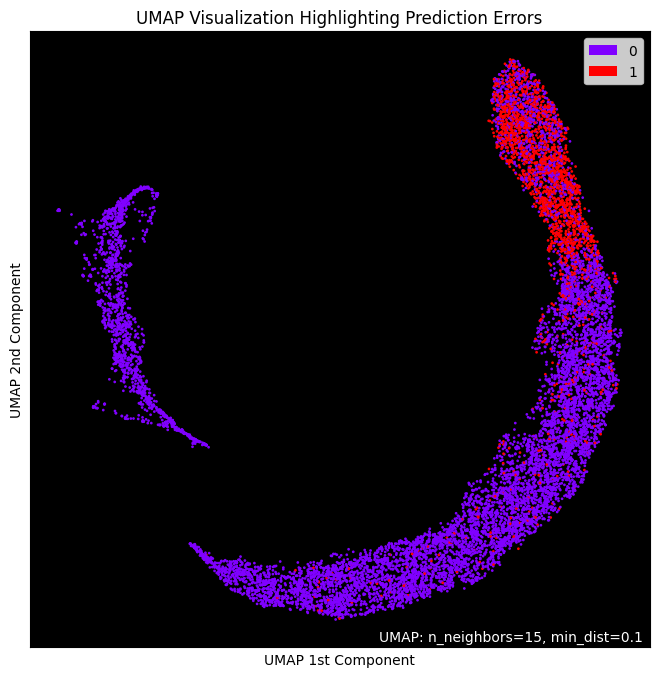

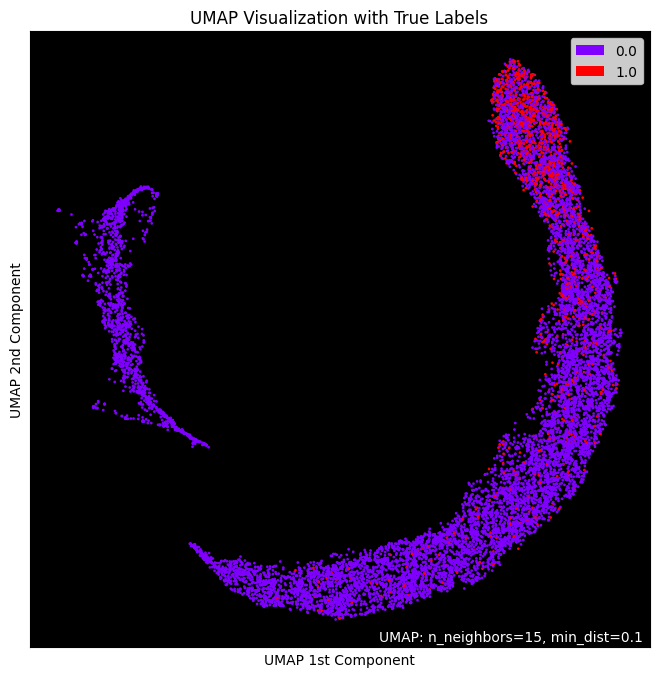

In [14]:
# Error and Label Lists
errors = [0 if y_pred[ix,0] == y_test.values[ix] else 1 for ix in range(len(y_pred[:,0]))]
labels = [y_test.values[ix] for ix in range(len(y_pred[:,0]))]

# Visualization using UMAP
umap.plot.points(mapper, labels=np.array(errors), theme='fire')
plt.gca().set_title('UMAP Visualization Highlighting Prediction Errors')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

umap.plot.points(mapper, labels=np.array(labels), theme='fire')
plt.gca().set_title('UMAP Visualization with True Labels')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

# # Scatter Plot for 2D UMAP Visualization
# x_coords = embedding[:, 0]
# y_coords = embedding[:, 1]
# plt.scatter(x_coords, y_coords, c=labels, cmap='jet', s=15, alpha=0.6, edgecolors='w')
# plt.xlabel('UMAP 1st component')
# plt.ylabel('UMAP 2nd component')
# plt.colorbar(label='Label')
# plt.title('2D UMAP Visualization with Labels')
# plt.show()

#### SHAP Analysis

In [ ]:
# SHAP analysis
import shap

# Convert pandas DataFrame to numpy array
X_train_scaled_new_array = np.array(X_train_scaled_new)
X_test_scaled_new_array = np.array(X_test_scaled_new)

# Use a smaller random sample for background
background_sample = X_train_scaled_new_array[np.random.choice(X_train_scaled_new_array.shape[0], 1000, replace=False)]

# Initialize the explainer object
explainer = shap.DeepExplainer(model, background_sample)

# Compute the SHAP values
shap_values = explainer.shap_values(X_test_scaled_new_array)

# Summary plot to show feature importance for the entire dataset
shap.summary_plot(shap_values, X_test_scaled_new_array)


In [ ]:
# feature_names
feature_names = X.columns.tolist()

# Convert numpy arrays back to DataFrames with appropriate feature names
X_train_scaled_new_df = pd.DataFrame(X_train_scaled_new_array, columns=feature_names)
X_test_scaled_new_df = pd.DataFrame(X_test_scaled_new_array, columns=feature_names)

# Use a smaller random sample for background
background_sample = X_train_scaled_new_df.sample(n=1000, replace=False)

# Initialize the explainer object
explainer = shap.GradientExplainer(model, background_sample)

# Compute the SHAP values
shap_values = explainer(X_test_scaled_new_df)

# Summary plot to show feature importance for the entire dataset using numpy array and feature names
shap.summary_plot(shap_values, X_test_scaled_new_df)


In [ ]:
# Using the first 100 training samples as the background dataset to compute SHAP values
background_data = [sample for sample in X_train_scaled_new[:100]]
background_data_array = np.array(background_data)

explainer = shap.GradientExplainer(model, background_data_array)
shap_values = explainer.shap_values(X_test_scaled_new)
shap.summary_plot(shap_values[0], X_test_scaled_new)



## Deep Neural Network (DNN)

In [15]:
# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=sample_weights, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 4s 4ms/step - loss: 0.5346 - accuracy: 0.6824 - val_loss: 0.4721 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4672 - accuracy: 0.7453 - val_loss: 0.4521 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4475 - accuracy: 0.7509 - val_loss: 0.4621 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4361 - accuracy: 0.7590 - val_loss: 0.4153 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4253 - accuracy: 0.7600 - val_loss: 0.4424 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4172 - accuracy: 0.7616 - val_loss: 0.4202 - val_accuracy: 0.7680 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                9664      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1

Plot Learning Curves

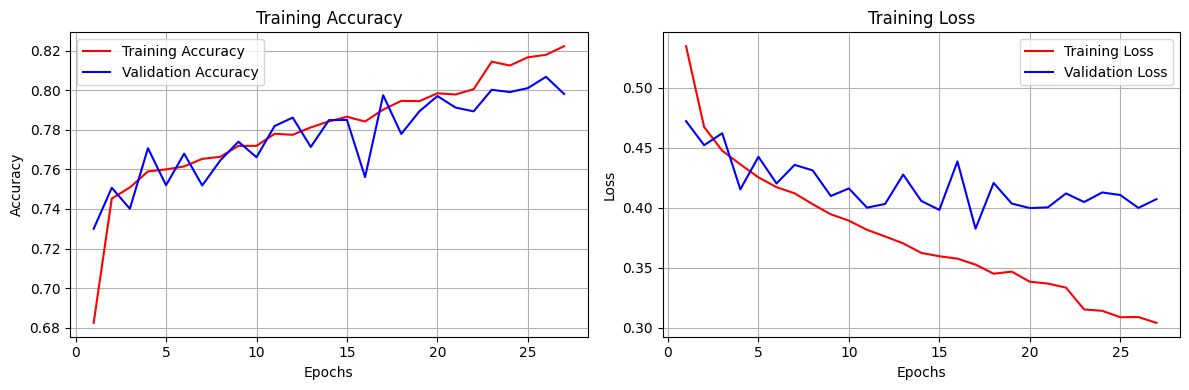

In [17]:
def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

**DNN Model Evaluation**

In [18]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)

1180/1180 [==============================] - 2s 1ms/step


In [19]:
print(classification_report(y_test, dnn_y_test_pred.round()))

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     10463
         1.0       0.32      0.79      0.46      1333

    accuracy                           0.79     11796
   macro avg       0.65      0.79      0.66     11796
weighted avg       0.89      0.79      0.82     11796



In [20]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

79.11% - Balanced accuracy Test
87.97% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

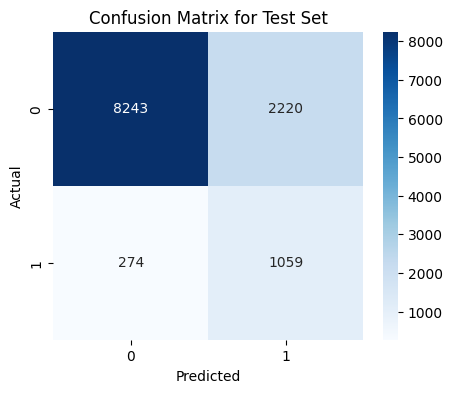

In [21]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, dnn_y_test_pred.round())
#train_cm = confusion_matrix(y_train, dnn_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

369/369 [==============================] - 1s 1ms/step


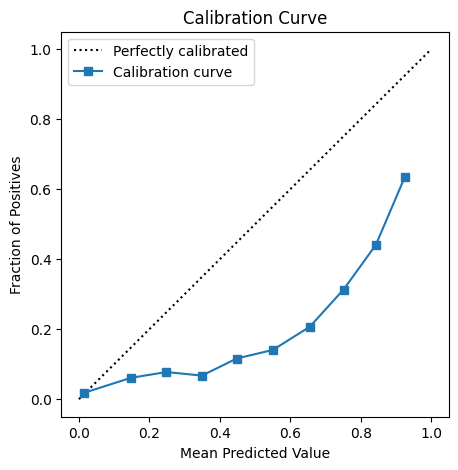

In [22]:
# calibration curve
# dnn_y_test_pred_proba = model.predict_proba(X_test_scaled)
# prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred_proba, n_bins=10, strategy='uniform')

dnn_y_test_pred = model.predict(X_test_scaled)
prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Perfectly Calibrated: In a perfectly calibrated model, the calibration curve would be a diagonal line, going from the bottom left corner to the top right corner of the plot (i.e., a 45-degree line, often labeled as "Perfectly calibrated").

Over-confident: If the curve is below the diagonal line, the model's predicted probabilities are generally higher than the actual fraction of positives, indicating over-confidence.

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [24]:
rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     10463
         1.0       0.68      0.08      0.14      1333

    accuracy                           0.89     11796
   macro avg       0.79      0.54      0.54     11796
weighted avg       0.87      0.89      0.85     11796



In [25]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

53.60% - Balanced accuracy Test
99.98% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

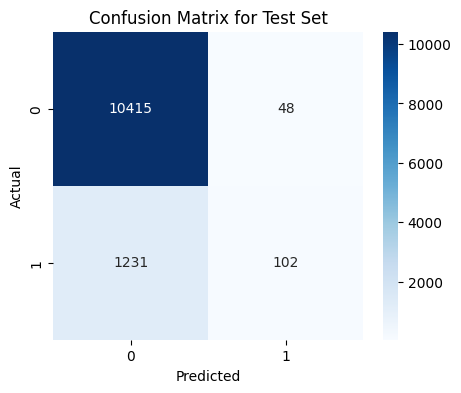

In [26]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, rf_y_pred.round())
train_cm = confusion_matrix(y_train, rf_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

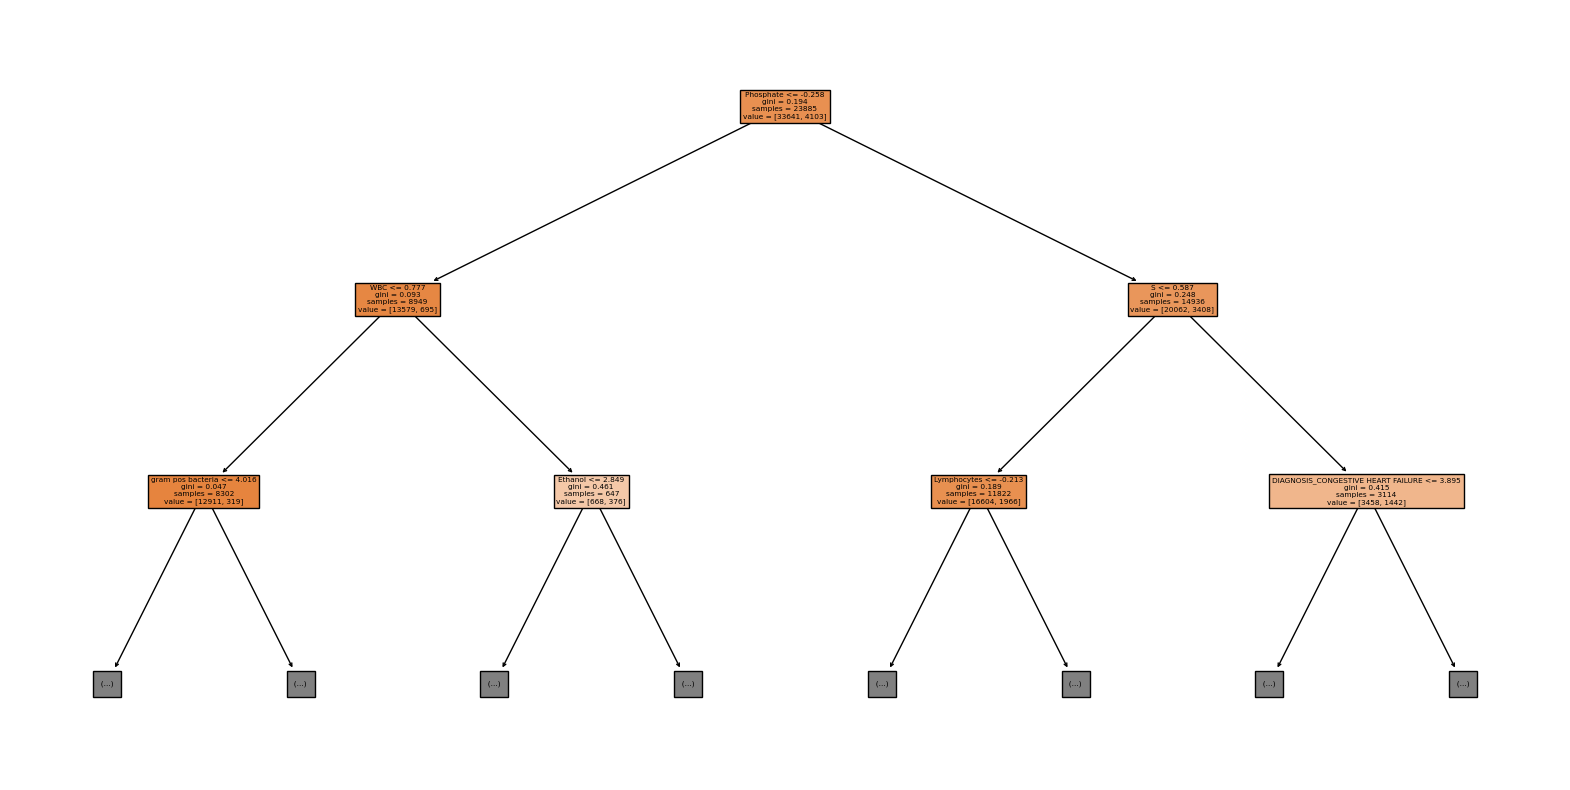

In [27]:
from sklearn.tree import plot_tree

# Visualizing the first decision tree
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, max_depth=2, feature_names=X.columns)
plt.show()

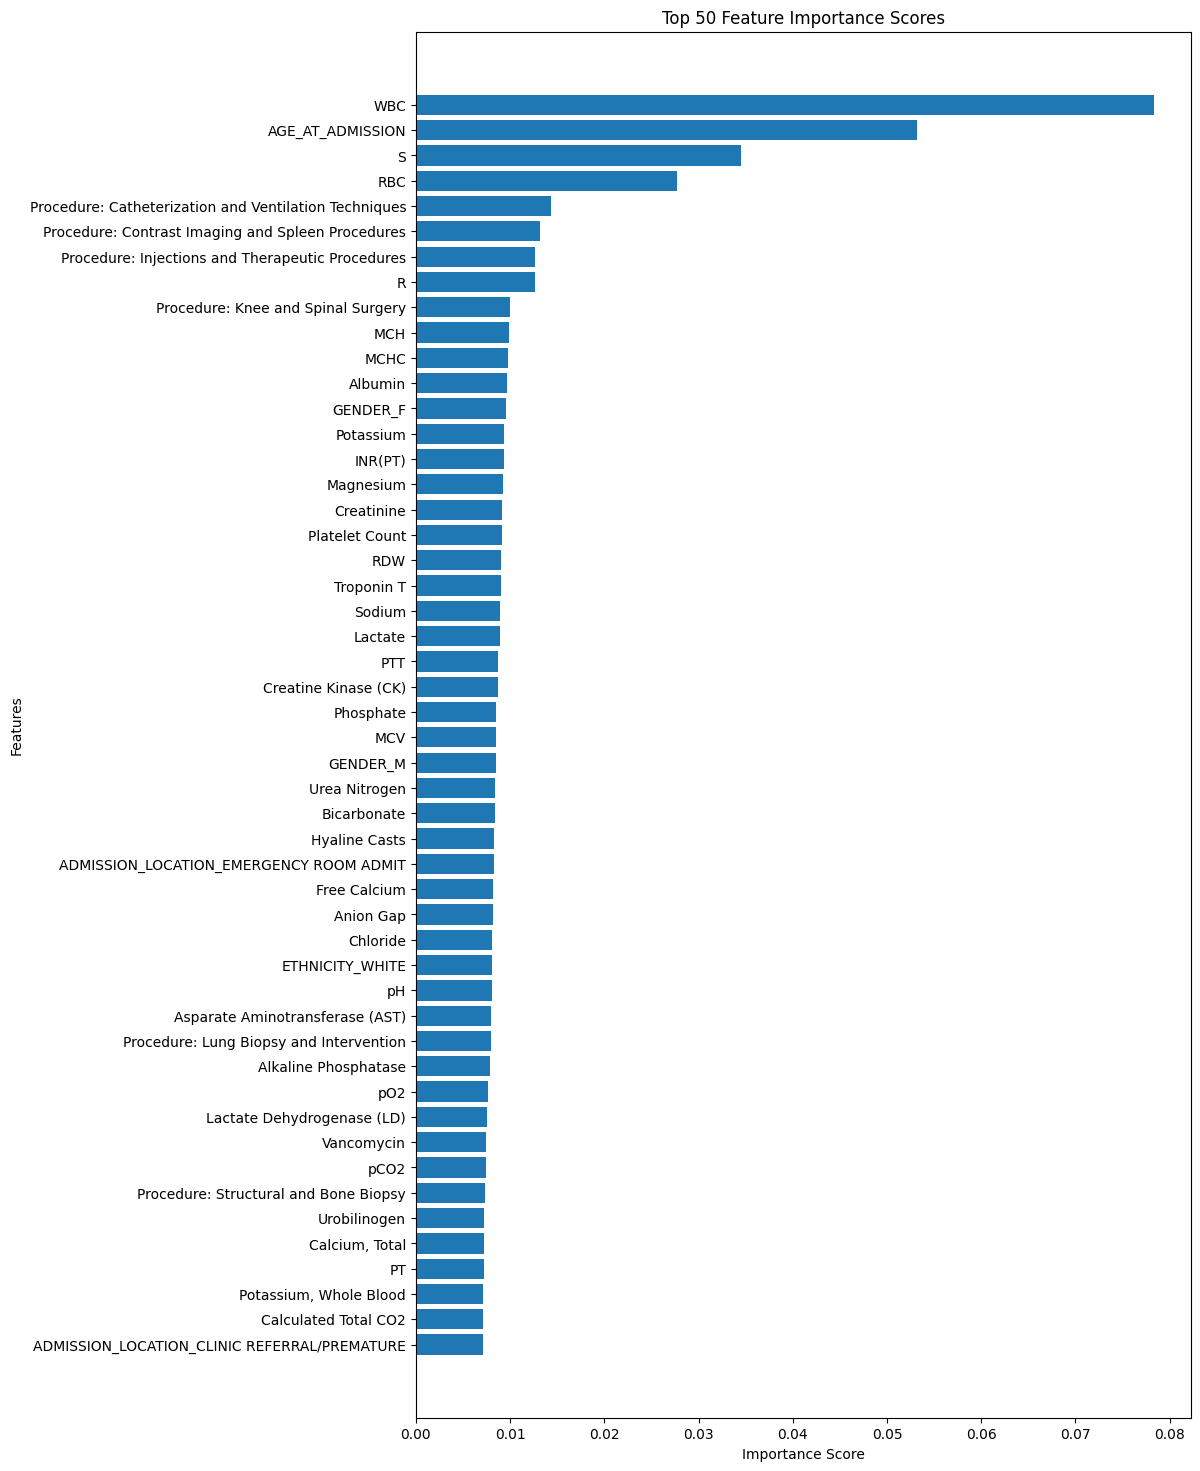

In [28]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top 50 features
sorted_indices = np.argsort(importances)[-50:]

plt.figure(figsize=(10,18))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


## XGBoost

In [29]:
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     10463
         1.0       0.51      0.24      0.33      1333

    accuracy                           0.89     11796
   macro avg       0.71      0.61      0.63     11796
weighted avg       0.86      0.89      0.87     11796



In [30]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

60.72% - Balanced accuracy Test
78.58% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

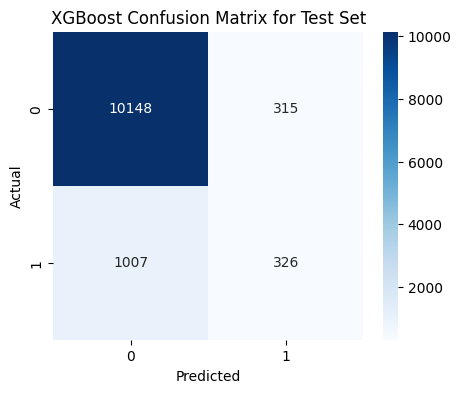

In [31]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, xgb_predictions.round())
train_cm = confusion_matrix(y_train, xgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('XGBoost Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## LightGBM

In [32]:
import lightgbm as lgb

# Create and train the model
lgb_model = lgb.LGBMClassifier(objective="binary", random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_train_predictions = lgb_model.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

[LightGBM] [Info] Number of positive: 4167, number of negative: 33577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110402 -> initscore=-2.086645
[LightGBM] [Info] Start training from score -2.086645
LightGBM Classification Report:

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     10463
         1.0       0.58      0.20      0.29      1333

    accuracy                           0.89     11796
   macro avg       0.74      0.59      0.62     11796
weighted avg       0.87      0.89      0.87     11796



In [33]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

58.93% - Balanced accuracy Test
66.17% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

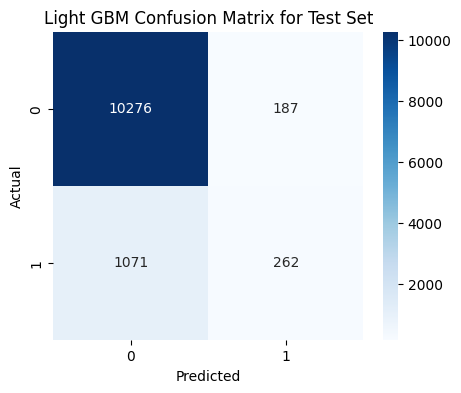

In [34]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, lgb_predictions.round())
train_cm = confusion_matrix(y_train, lgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Light GBM Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create and train the model with balanced class weights and increased iterations
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict using test set
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_train_predictions = logistic_model.predict(X_train_scaled)

# Show classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, logistic_predictions))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88     10463
         1.0       0.34      0.79      0.48      1333

    accuracy                           0.80     11796
   macro avg       0.65      0.80      0.68     11796
weighted avg       0.90      0.80      0.83     11796



In [36]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, logistic_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, logistic_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

79.83% - Balanced accuracy Test
79.83% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

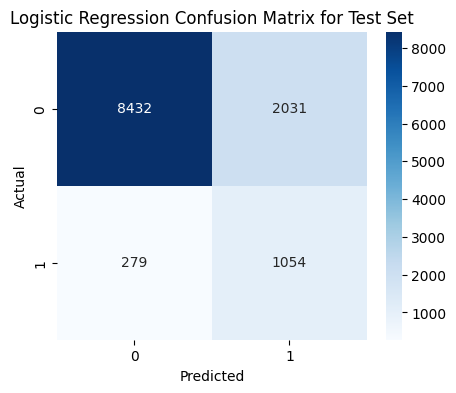

In [37]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, logistic_predictions.round())
train_cm = confusion_matrix(y_train, logistic_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Logistic Regression Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

**SHAP (SHapley Additive exPlanations)**

Explain the output of machine learning models and identifying feature importance by using Shapley values to fairly allocate contributions of each feature for individual predictions.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


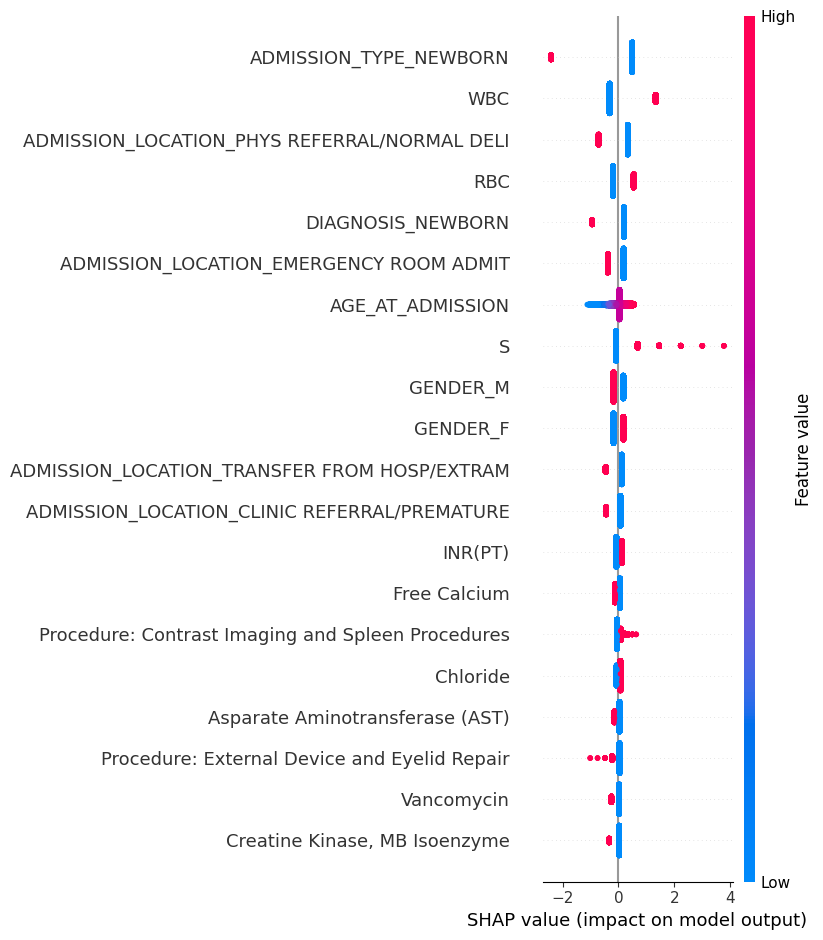

In [38]:

# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object with the appropriate masker
masker = shap.maskers.Independent(data=X_train_scaled)
explainer = shap.LinearExplainer(logistic_model, masker=masker)

# Compute SHAP values for a particular set (e.g., test set)
shap_values = explainer(X_test_scaled)

# force plot for the first instance
# shap.initjs()
# shap.plots.force(shap_values[0])

# Summary plot to show feature importance for the entire dataset
shap.summary_plot(shap_values, X_test_scaled)

Red: Feature has a high value for that observation

Blue: Feature has a low value for that observation

Position on the x-axis: Indicates the effect of that value on the output

## ROC Curve for all models

369/369 [==============================] - 1s 1ms/step


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


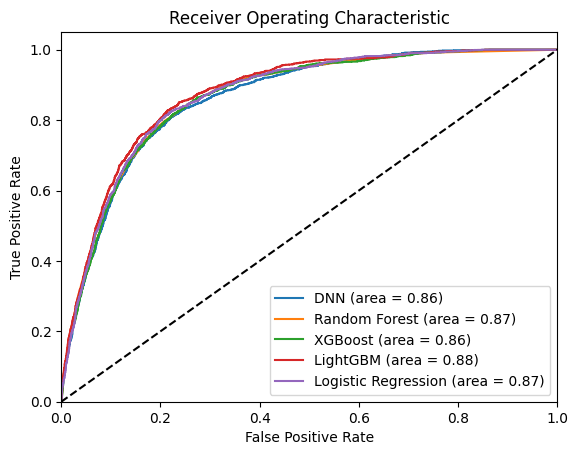

In [39]:
from sklearn.metrics import roc_curve, auc

# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# For Random Forest
y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# For XGBoost
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# For LightGBM
y_pred_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# For Logistic Regression
y_pred_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting
plt.figure()
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (area = {roc_auc_dnn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (area = {roc_auc_lgb:.2f})')
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (area = {roc_auc_logistic:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
